In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [2]:
df= pd.read_csv('diamonds.csv',index_col=0)

In [3]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [5]:
# check for missing values
df.isna().any().any()

False

In [6]:
# check for duplicates
df.duplicated().sum()

146

In [7]:
# remove duplicates
df.drop_duplicates(inplace=True)

In [8]:
df.describe() # numerical only

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [9]:
numeric_cols = [col for col in df.columns if df[col].dtype in ['int64','float64']]

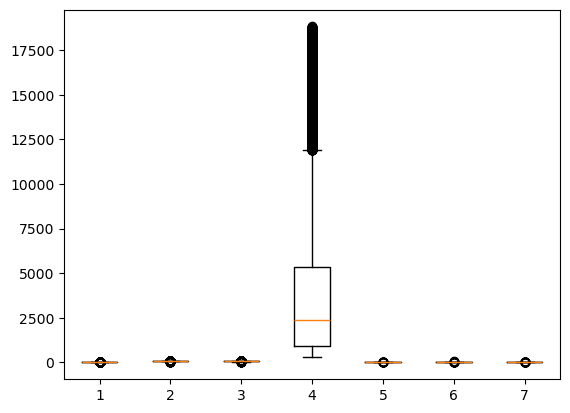

In [10]:
plt.boxplot(df[numeric_cols])
plt.show()

<Axes: >

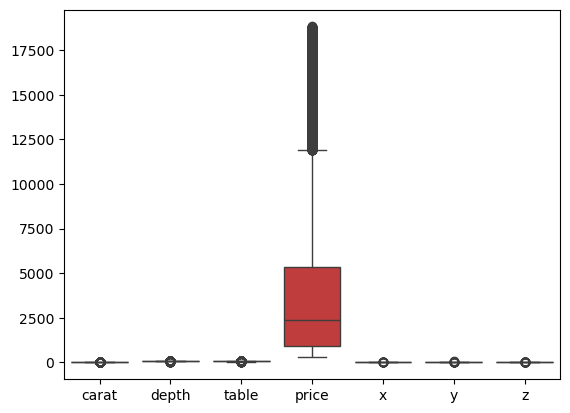

In [11]:
sns.boxplot(df)

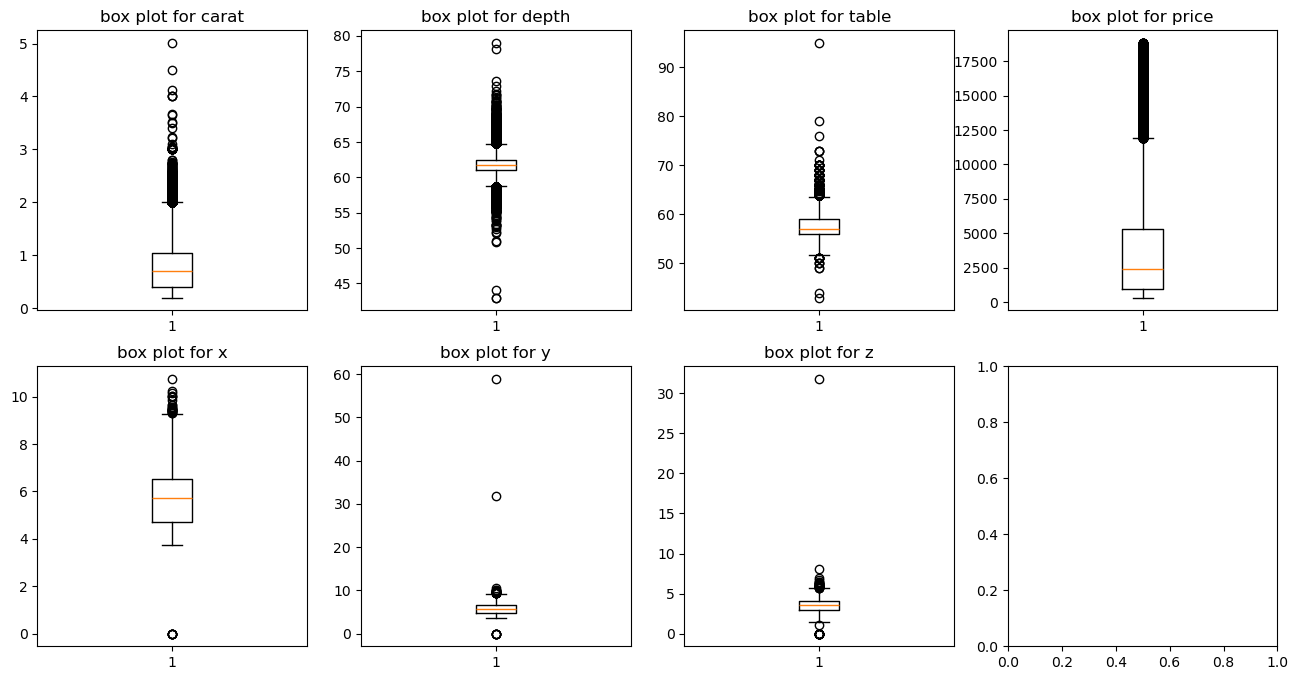

In [12]:
fig,axes= plt.subplots(2,4)
fig.set_size_inches(16,8)
for i in range(len(numeric_cols)):   
    if i<4:
        axes[0,i].boxplot(df[numeric_cols[i]])        
        axes[0,i].set_title(f'box plot for {numeric_cols[i]}')
    else:
        axes[1,i-4].boxplot(df[numeric_cols[i]])
        axes[1,i-4].set_title(f'box plot for {numeric_cols[i]}')

plt.show()
# plt.boxplot(df[numeric_cols])

looks like there are so many outliers

### splitting features and label

In [13]:
 #splitting features and label
X= df.drop('price',axis=1)
y= df.price

### splitting training and test data

In [14]:
# splitting training set and test set

X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=0.2, random_state=4)

*To avoid `Data Leakage` performing feature engineering after train test split is a good practise.*

## Feature Engineering

In [15]:
categorical_cols= [col for col in df.columns if df[col].dtype =='object']
for col in categorical_cols:
    print(col, df[col].nunique())

cut 5
color 7
clarity 8


- no problem with the categorical values we can encode them
- since the cardinality is low we can use OneHotEncoder instead of Ordinal Encoder

### Here numerical features are within the range (0,100) so no need to feature scaling
```
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

X_new= df.drop('price',axis=1)
y_new= df.price

ct= ColumnTransformer(transformers=[('one-hot',OneHotEncoder(sparse_output=False),[1,2,3]),
                                   ('scalar', StandardScaler(),[0,4,5,7,8])], remainder='passthrough')
X_new= ct.fit_transform(X_new)

new_X_train,new_X_test,new_y_train,new_y_test= train_test_split(X_new,y, test_size=0.2, random_state=4)

lin= LinearRegression()
lin.fit(new_X_train, new_y_train)
lin.score(new_X_train, new_y_train)
```

#### encoding Categorical Data

In [16]:
# encoding categorical values
oh_encoder= OneHotEncoder(sparse_output=False, drop=None)
train_encoded= oh_encoder.fit_transform(X_train[categorical_cols])
test_encoded= oh_encoder.transform(X_test[categorical_cols])

# all possible feature columns 
cat_features= oh_encoder.get_feature_names_out(categorical_cols)

# append to features dataset
X_train[cat_features] = train_encoded
X_test[cat_features] = test_encoded

# remove categorical cols
X_train.drop(categorical_cols, axis=1, inplace = True)
X_test.drop(categorical_cols, axis=1, inplace = True)

### Metric Function

In [17]:
def show_scores(model, X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    train_preds= model.predict(X_train)
    test_preds= model.predict(X_test)
    print('Train score',r2_score(y_train,train_preds))
    print('Test score',r2_score(y_test,test_preds))
    print('Train MAE',mean_absolute_error(y_train,train_preds))
    print('Test MAE',mean_absolute_error(y_test, test_preds))
    print('Train MSE',mean_squared_error(y_train,train_preds))
    print('Train MSE',mean_squared_error(y_test, test_preds))
    

### Training Models

In [18]:
lin_reg= LinearRegression()
knn= KNeighborsRegressor()
tree_model= DecisionTreeRegressor()
rf_model= RandomForestRegressor()

for model in [lin_reg, knn, tree_model, rf_model]:
    print('\n',model)
    show_scores(model, X_train,X_test,y_train,y_test)
    


 LinearRegression()
Train score 0.9202696849036979
Test score 0.9182945943881535
Train MAE 738.0665105437434
Test MAE 734.347107654057
Train MSE 1275166.4264262328
Train MSE 1270504.967065273

 KNeighborsRegressor()
Train score 0.9634765743787023
Test score 0.9477872835515081
Train MAE 403.4239665388637
Test MAE 492.6549679338229
Train MSE 584137.2390677356
Train MSE 811898.7366260806

 DecisionTreeRegressor()
Train score 0.9999969122373569
Test score 0.9670820730672585
Train MAE 0.39853607528755663
Test MAE 352.71163676921645
Train MSE 49.384117578715
Train MSE 511868.0870666419

 RandomForestRegressor()
Train score 0.9973296521088171
Test score 0.9810945959909985
Train MAE 101.46867305921168
Test MAE 267.1569450493275
Train MSE 42708.19667025828
Train MSE 293975.77207951125


here in decision tree the model seems to be over fitted let's tune hyperparameter and try again

### More things to cover
- hyperparameter tuning
- Model selection
    - RandomizedSearchCV
    - GridSearchCV
- Boosting
    - XGBoost

### XGBoosting 

In [19]:
from xgboost import XGBRegressor
show_scores(XGBRegressor(), X_train,X_test,y_train,y_test)

Train score 0.9896641373634338
Test score 0.9810473918914795
Train MAE 229.28807084074805
Test MAE 279.4572557962919
Train MSE 165306.67740863762
Train MSE 294709.6985736541


### Model selection
- k-fold cross validation

In [20]:
%%time
params= {'n_estimators':np.arange(10,200,45),          
            'max_depth': [None, 10, 20, 30, 50],     
            'min_samples_split': [2, 5, 10],         
            'min_samples_leaf': [1, 2, 4], 
             'max_samples':[30000],
             'max_features': [0.5, 1, 'sqrt']
}

rn_model = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=params,
                            scoring='r2', n_iter=10, verbose=3,
                          cv=5, n_jobs=-1, random_state=4)

rn_model.fit(X_train,y_train)

# Display best parameters and score
print("Best Parameters:", rn_model.best_params_)
print("Best R² Score:", rn_model.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 55, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 30000, 'max_features': 0.5, 'max_depth': 20}
Best R² Score: 0.9800574989811797
CPU times: total: 5.97 s
Wall time: 49.1 s


### ideal model 

In [21]:
ideal_model= RandomForestRegressor(n_estimators=55, min_samples_split=2, min_samples_leaf=2,
                                   max_depth= 20,  max_features=0.5, 
                                   n_jobs=-1, random_state=4 )
ideal_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, max_features=0.5, min_samples_leaf=2,
                      n_estimators=55, n_jobs=-1, random_state=4)

In [22]:
ideal_model.score(X_train,y_train), ideal_model.score(X_test,y_test)

(0.9939075565919161, 0.9814347653434746)

 ***The model seems to perform well on both training and test data.***